# X-ray binary LS V +44 17
#### Mary Geer Dethero, NICER intern, Summer 2023

 ## Contents:
 * [Plotting spectrum with PyXspec](#xspec)
 * [Creating Lightcurves with Astropy](#first-bullet)
 * [Calculating the Hardness ratio](#second-bullet)
 * [Hardness Intensity Diagram](#HID)
 * [Creating Lightcurves with Stingray](#third-bullet)
 * [Z1 Squared Statistics](#fourth-bullet)
 * [Pulse Profile](#fifth-bullet)

## Import Packages 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #for Joel's hardness ratio function
from astropy.io import fits
from astropy.table import Table

In [2]:
from xspec import * #for plotting spectra and modeling spectra

In [3]:
#stingray package for timing analysis
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList, Lightcurve, Powerspectrum
from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
import copy
from stingray.pulse.search import epoch_folding_search, z_n_search
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile

### Using Pyxspec

#### The " .../ni...load.py " file contains the spectra for  "spec1" and "spec 2". It loads in the background, response, and arf files.

In [4]:
exec(open('5203610109/xti/event_cl/ni5203610109mpu7_load.py').read())#file created from nicerl3-spect (specify "outlang=PYTHON")


1 spectrum  in use
 
Spectral Data File: 5203610109/xti/event_cl/ni5203610109mpu7_sr.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.279e+02 +/- 4.814e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-221
  Telescope: NICER Instrument: XTI  Channel Type: PI
  Exposure Time: 1.546e+04 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.

Net count rate (cts/s) for Spectrum:1  3.264e+02 +/- 4.814e-01 (99.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.
Arf successfully loaded.


***Xspec Error: Invalid ignore/notice string: 1:bad


In [5]:
# Learn about the plotting command:
#Plot("?")

#### Ignore energy ranges in units of kev for "AllData" or just one of the sources "spec1"

In [6]:
AllData.ignore("**-0.7")
AllData.ignore("10.0-**")

    13 channels (1-13) ignored in spectrum #     1

    46 channels (176-221) ignored in spectrum #     1



#### Set plot device to null so that a new window does not open. Put data into matplotlib.

In [7]:
Plot.device = "/null" #can set to "/xs" for pop up window
Plot.xAxis="kev"
Plot("ldata")

In [8]:
#spectrum 1 data
energies = Plot.x(plotGroup=1)
edeltas = Plot.xErr(plotGroup=1)
rates = Plot.y(plotGroup=1)
errors = Plot.yErr(plotGroup=1)
labels = Plot.labels()

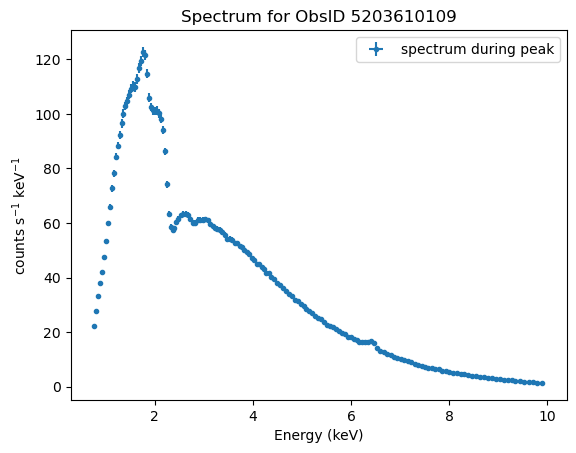

In [9]:
#plt.yscale('log')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.title("Spectrum for ObsID 5203610109")
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.', label='spectrum during peak')
plt.legend()
plt.show()

In [10]:
AllData.show()


1 file 1 spectrum 
Spectrum 1  Spectral Data File: 5203610109/xti/event_cl/ni5203610109mpu7_sr.pha
Net count rate (cts/s) for Spectrum:1  3.221e+02 +/- 4.797e-01 (99.7 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  14-175
  Telescope: NICER Instrument: XTI  Channel Type: PI
  Exposure Time: 1.546e+04 sec
 Using fit statistic: chi
 Using Background File                5203610109/xti/event_cl/ni5203610109mpu7_bg.pha
  Background Exposure Time: 8.963e+04 sec
 Using Response (RMF) File            5203610109/xti/event_cl/ni5203610109mpu7.rmf for Source 1
 Using Auxiliary Response (ARF) File  5203610109/xti/event_cl/ni5203610109mpu7.arf



### Define model to include: 
    1. TB absorption (stuff between NICER and binary system)
    2. Powerlaw (photon index = 1.15)
    3. Black body (kT = 2.17ev)
    4. Gaussian (Fe line at 6.44)

In [11]:
m = Model("tbabs*(power+bbody+gauss)")
m.setPars(0.497599 ,0.839473 ,9.93062E-02 ,2.19446 , 3.01403E-02 ,6.41125,7.70380E-02, 1.78186E-03  )
#m.setPars(3.3 ,1.15 ,25, 2.17 , 0.6 ,6.44,.359, 1.1  )


Model TBabs<1>(powerlaw<2> + bbody<3> + gaussian<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
   4    3   bbody      kT         keV      3.00000      +/-  0.0          
   5    3   bbody      norm                1.00000      +/-  0.0          
   6    4   gaussian   LineE      keV      6.50000      +/-  0.0          
   7    4   gaussian   Sigma      keV      0.100000     +/-  0.0          
   8    4   gaussian   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.542139e+08     using 162 bins.

Test statistic : Chi-Squared              1.542139e+08     using 162 bins.
 Null hypothesis probability of 0.

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.


In [12]:
#list all model components and their parameters
ncomp = len(m.componentNames)
for icomp in m.componentNames:
    print (icomp,eval(f'm.{icomp}.parameterNames'))

TBabs ['nH']
powerlaw ['PhoIndex', 'norm']
bbody ['kT', 'norm']
gaussian ['LineE', 'Sigma', 'norm']


In [13]:
m.TBabs.nH=0.497599
m.TBabs.nH.frozen = True

m.powerlaw.PhoIndex=0.839473
m.powerlaw.norm=9.93062E-02
m.powerlaw.norm.frozen = False

# Wien's law, the temperature in kT units [keV] of a BB peaking at 6.5 keV
m.bbody.kT = 2.19446#6.5/1.59362 
m.bbody.norm =3.01403E-02
# and freeze the temp and normalization
m.bbody.kT.frozen = False
m.bbody.norm.frozen = False

# initial sigma of the line is set to 50 eV, but can be between 1 and 100 eV
m.gaussian.LineE= 6.41125
m.gaussian.Sigma = 7.70380E-02 
m.gaussian.norm = 1.78186E-03 
m.gaussian.LineE.frozen = False
m.gaussian.Sigma.frozen = False
m.gaussian.norm.frozen = False


Fit statistic  : Chi-Squared                   73.83     using 162 bins.

Test statistic : Chi-Squared                   73.83     using 162 bins.
 Null hypothesis probability of 1.00e+00 with 154 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared                   73.83     using 162 bins.

Test statistic : Chi-Squared                   73.83     using 162 bins.
 Null hypothesis probability of 1.00e+00 with 155 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared                   73.83     using 162 bins.

Test statistic : Chi-Squared                   73.83     using 162 bins.
 Null hypothesis probability of 1.00e+00 with 155 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared                   73.83     using 162 bins.

Test statistic : Chi-Squared                   73.83     using 162 bins.
 Null hypothesis probability of 1.00e+00 with 155 degrees of freedom
 Current data and mod

#### Set abundances to Wilms et al

In [14]:
Xset.abund ="wilm"

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

Fit statistic  : Chi-Squared                15725.52     using 162 bins.

Test statistic : Chi-Squared                15725.52     using 162 bins.
 Null hypothesis probability of 0.00e+00 with 155 degrees of freedom
 Current data and model not fit yet.


In [15]:
# will constrain the spectrum in [0.7-10] keV
startE = 0.7 # keV
endE = 10.0 # keV

AllData.notice("all")
AllData.ignore(f"**-{startE} {endE}-**")

   221 channels (1,221) noticed in spectrum #     1

All channels noticed
Fit statistic  : Chi-Squared                35206.01     using 221 bins.

Test statistic : Chi-Squared                35206.01     using 221 bins.
 Null hypothesis probability of 0.00e+00 with 214 degrees of freedom
 Current data and model not fit yet.

    13 channels (1-13) ignored in spectrum #     1
    46 channels (176-221) ignored in spectrum #     1

Fit statistic  : Chi-Squared                15725.52     using 162 bins.

Test statistic : Chi-Squared                15725.52     using 162 bins.
 Null hypothesis probability of 0.00e+00 with 155 degrees of freedom
 Current data and model not fit yet.



In [16]:
Fit.renorm()


Fit statistic  : Chi-Squared                10571.38     using 162 bins.

Test statistic : Chi-Squared                10571.38     using 162 bins.
 Null hypothesis probability of 0.00e+00 with 155 degrees of freedom
 Current data and model not fit yet.


In [17]:
Fit.perform()

                                   Parameters
Chi-Squared  |beta|/N    Lvl    2:PhoIndex        3:norm          4:kT        5:norm       6:LineE       7:Sigma        8:norm
3448.24      55846.4      -3      0.368062     0.0623307       1.73285     0.0129239       6.41180     0.0941767    0.00209749
661.436      106929       -4      0.387907     0.0558126       1.59702     0.0181931       6.41197      0.109131    0.00241209
427.2        35706.2      -5      0.385952     0.0555105       1.63445     0.0180991       6.41223      0.118358    0.00253533
426.555      602.028      -6      0.387059     0.0555004       1.63854     0.0181808       6.41268      0.124138    0.00258653
426.374      12.0052      -7      0.386705     0.0554868       1.63752     0.0181579       6.41302      0.128308    0.00262548
426.275      5.59534      -8      0.386383     0.0554758       1.63661     0.0181371       6.41330      0.131439    0.00265474
426.218      3.32392      -9      0.386136     0.0554673       1.

In [18]:
m.show()


Model TBabs<1>(powerlaw<2> + bbody<3> + gaussian<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    0.497599     frozen
   2    2   powerlaw   PhoIndex            0.385577     +/-  9.03513E-03  
   3    2   powerlaw   norm                5.54479E-02  +/-  5.35305E-04  
   4    3   bbody      kT         keV      1.63435      +/-  1.79156E-02  
   5    3   bbody      norm                1.80855E-02  +/-  4.50707E-04  
   6    4   gaussian   LineE      keV      6.41409      +/-  1.24522E-02  
   7    4   gaussian   Sigma      keV      0.139402     +/-  1.37194E-02  
   8    4   gaussian   norm                2.72792E-03  +/-  2.08595E-04  
________________________________________________________________________



### Plot spectrum, model, and chi-squared<a class="anchor" id="xspec"></a>

In [19]:
# reset the plot
Plot.commands = ()

Plot command list is now empty


In [20]:
Plot("ldata ratio")
Plot.xAxis="kev"
energies = Plot.x(plotGroup=1, plotWindow=1)
edeltas = Plot.xErr(plotGroup=1, plotWindow=1)
rates = Plot.y(1,1)
errors = Plot.yErr(1,1)
foldedmodel = Plot.model()
dataLabels = Plot.labels(1)
chiLabels = Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
chi = Plot.y(1,2)
chi.append(chi[-1])

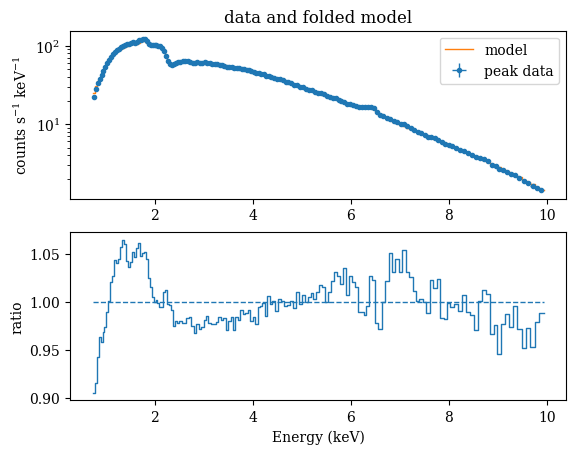

In [21]:
#for plotting in matplotlib
plt.rcParams.update({'font.size':10,'lines.linewidth':1, 'font.family':'serif','mathtext.fontset':'dejavuserif'})
plt.subplot(211)
plt.yscale('log')
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.', label = 'peak data')
plt.step(stepenergies,foldedmodel,where='post', label='model')
plt.legend()

plt.subplot(212)
plt.xlabel(chiLabels[0])
plt.ylabel(chiLabels[1])
plt.step(stepenergies,chi,where='post')
plt.hlines(1.0,stepenergies[0],stepenergies[-1],linestyles='dashed')

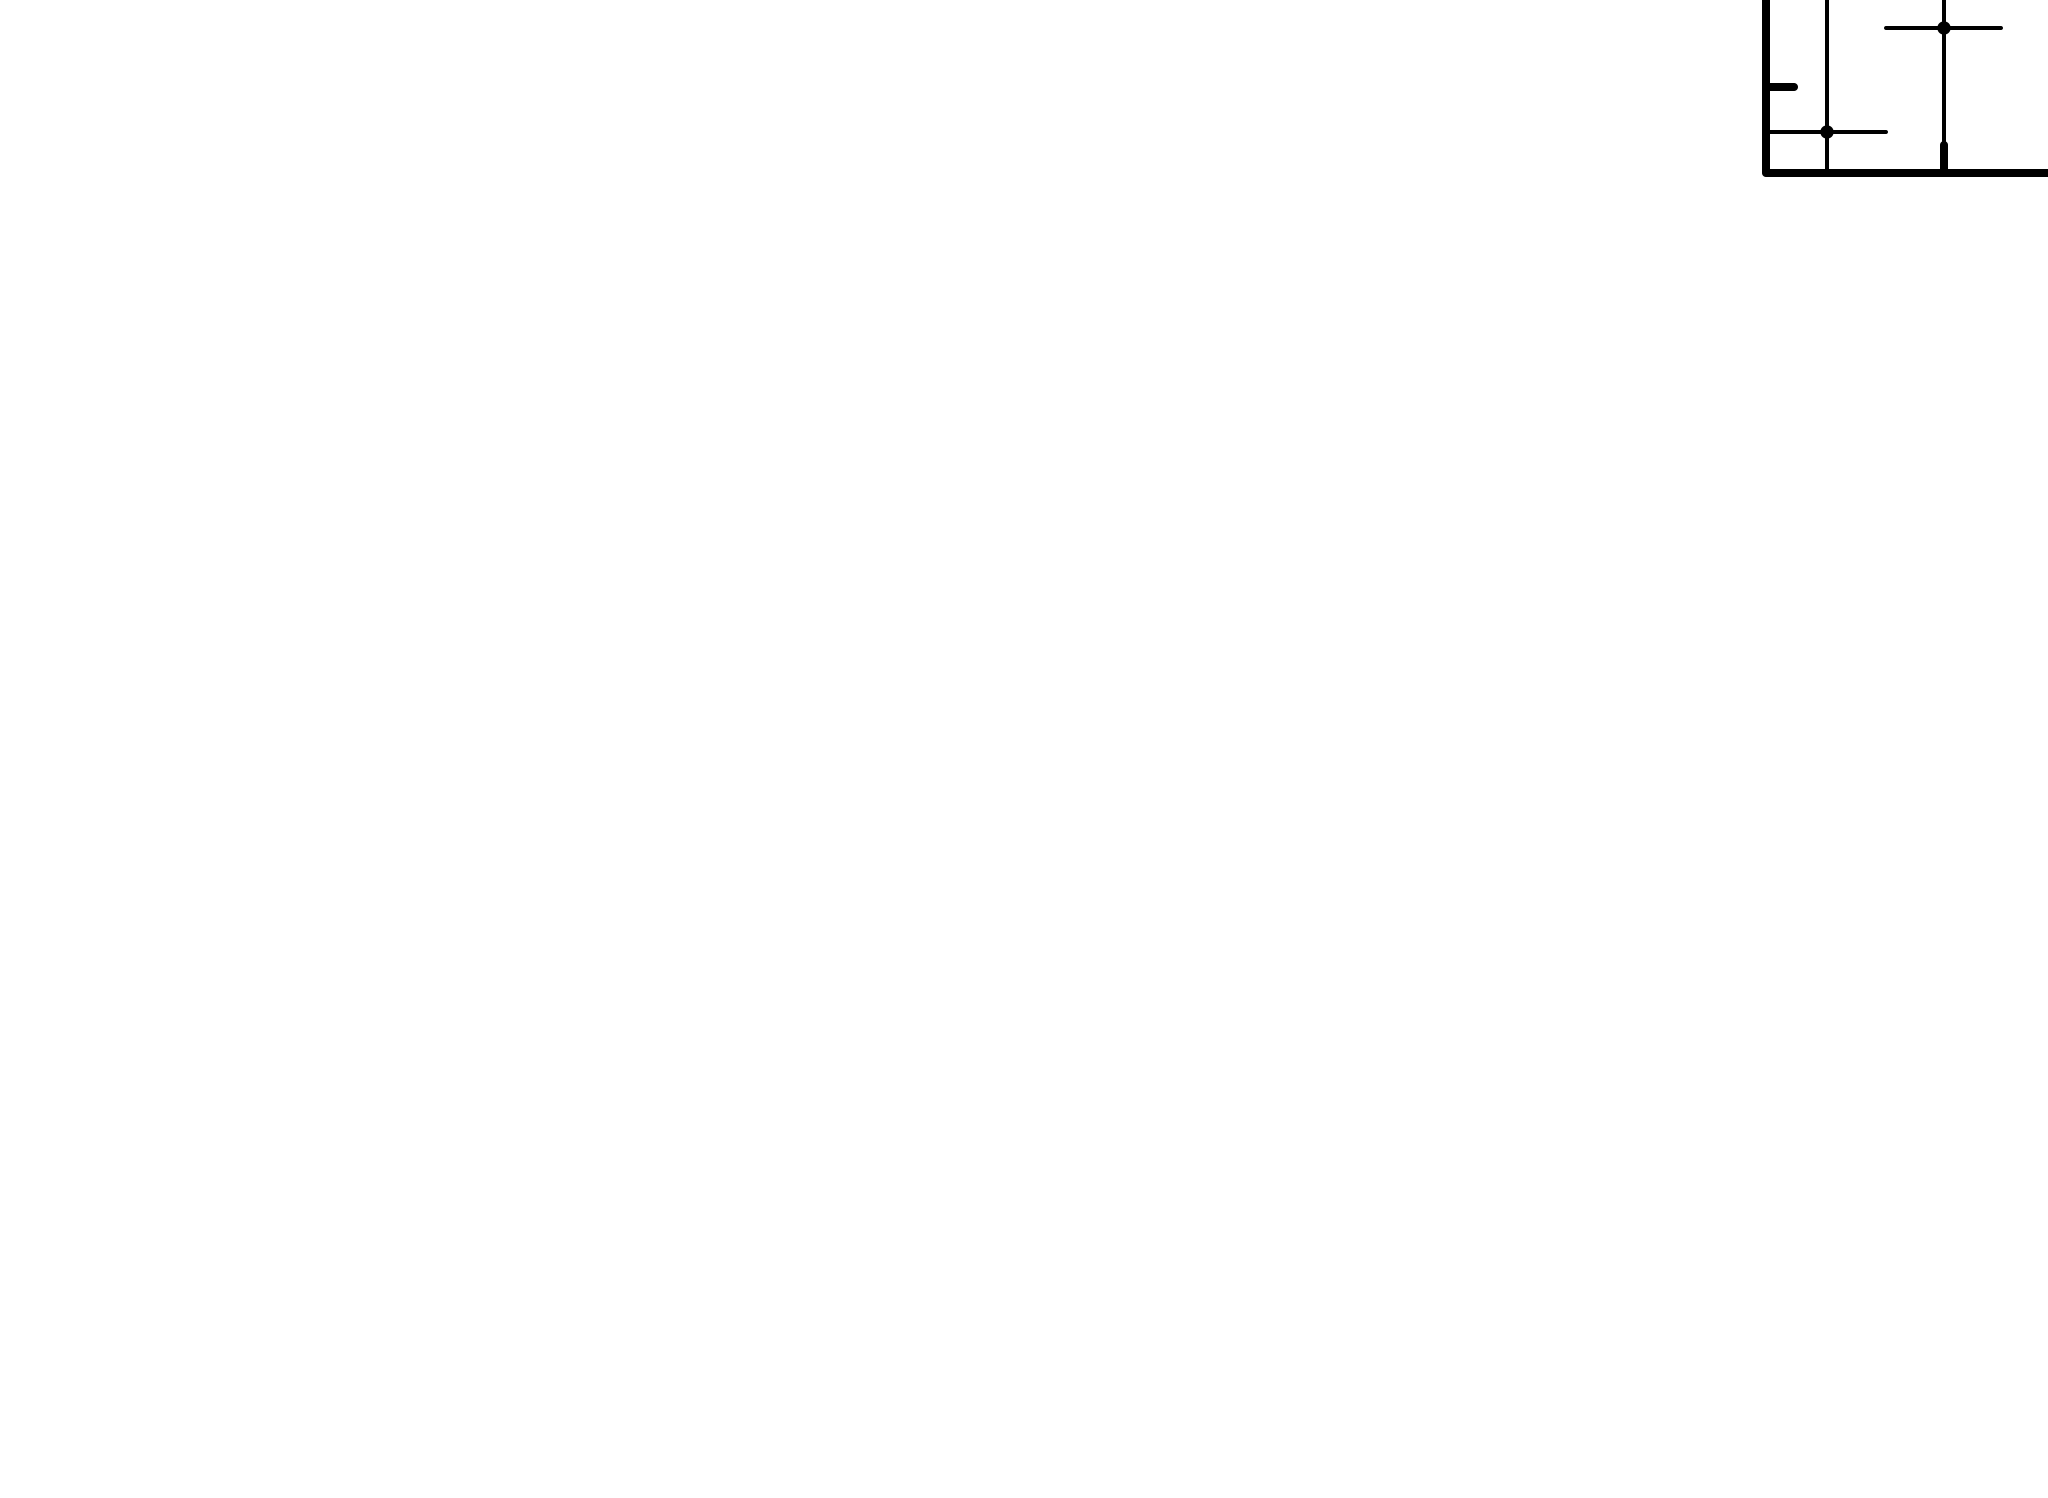

In [22]:
#for plotting svg in notebook
Plot.add=True
Plot.device="/svg"
Plot(" ldata ratio")
Plot.xAxis="kev"

## Creating light curves with astropy <a class="anchor" id="first-bullet"></a>


### Import light curves in two different energy ranges, plus the full spectrum:
#### 'soft09_60' represents lower energy xray range, obsID 5203610109, and bin size 60 seconds.

In [23]:
#obsID=5203610109, bins=60
soft09_60 = '5203610109/xti/event_cl/ni5203610109mpu7_2to4_sr.lc' #for Astropy
hard09_60 = '5203610109/xti/event_cl/ni5203610109mpu7_4to10_sr.lc'
tot09_60 = '5203610109/xti/event_cl/ni5203610109mpu7_totE_sr.lc'

In [24]:
#obsID=5203610136, bins=60
soft22_60 = "5203610122/xti/event_cl/ni5203610122mpu7_2to4_sr.lc"
hard22_60 = "5203610122/xti/event_cl/ni5203610122mpu7_4to10_sr.lc"
tot22_60 = "5203610122/xti/event_cl/ni5203610122mpu7_2to10_sr.lc"

In [25]:
#obsID=5203610136, bins=60
soft36_60 = "5203610136/xti/event_cl/ni5203610136mpu7_2to4_sr.lc"
hard36_60 = "5203610136/xti/event_cl/ni5203610136mpu7_4to10_sr.lc"
tot36_60 = "5203610136/xti/event_cl/ni5203610136mpu7_2to10_sr.lc"

In [26]:
#obsID=5203610150, bins=60
soft50_60 = "5203610150/xti/event_cl/ni5203610150mpu7_2to4_sr.lc"
hard50_60 = "5203610150/xti/event_cl/ni5203610150mpu7_4to10_sr.lc"
tot50_60 = "5203610150/xti/event_cl/ni5203610150mpu7_2to10_sr.lc"

In [27]:
#see what columns we can use
softdata = fits.open(soft09_60, memmap=True)
softdata.info()
print(softdata[1].columns)

Filename: 5203610109/xti/event_cl/ni5203610109mpu7_2to4_sr.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  RATE          1 BinTableHDU    256   266R x 4C   [D, E, E, E]   
  2  GTI           1 BinTableHDU     50   19R x 2C   [1D, 1D]   
ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count/s'
    name = 'ERROR'; format = 'E'; unit = 'count/s'
    name = 'FRACEXP'; format = 'E'
)


### Write function to read data for light curves.

#### Assign data to arrays: time, rate, and error.

In [28]:
def lc_data(filename):
    alldata = fits.open(filename, memmap=True)
    lc_table = Table(alldata[1].data)
    header=Table(alldata[0].data)
    time=lc_table['TIME']
    rate= lc_table['RATE']
    err=lc_table['ERROR']
    return(time,rate,err)

### Light curve for soft, hard, and total data in ObsID 5203610109

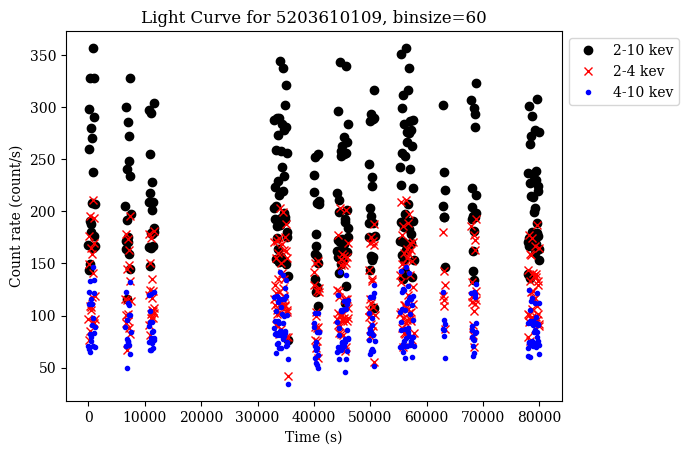

In [29]:
plt.plot(lc_data(tot09_60)[0],lc_data(tot09_60)[1], 'o',color='black', label='2-10 kev')
plt.plot(lc_data(soft09_60)[0],lc_data(soft09_60)[1], 'red', marker='x',linestyle='', label='2-4 kev')
plt.plot(lc_data(hard09_60)[0],lc_data(hard09_60)[1], 'blue', marker='.', linestyle='', label='4-10 kev')

plt.title("Light Curve for 5203610109, binsize=60")
plt.xlabel("Time (s)")
plt.ylabel("Count rate (count/s)")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

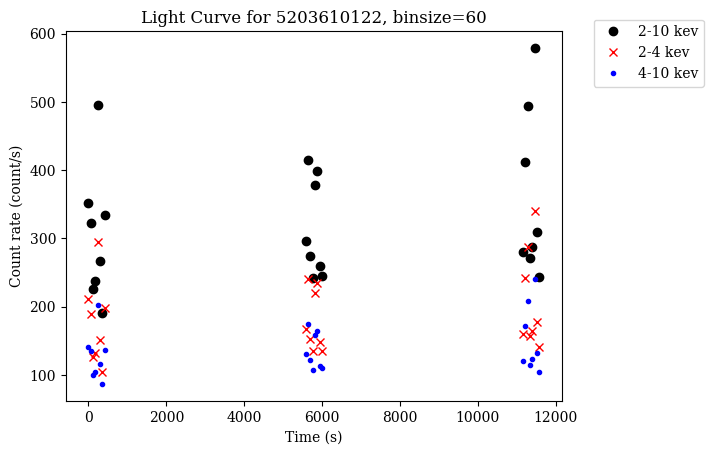

In [30]:
plt.plot(lc_data(tot22_60)[0],lc_data(tot22_60)[1], 'o',color='black', label='2-10 kev')
plt.plot(lc_data(soft22_60)[0],lc_data(soft22_60)[1], 'red', marker='x',linestyle='', label='2-4 kev')
plt.plot(lc_data(hard22_60)[0],lc_data(hard22_60)[1], 'blue', marker='.',linestyle='', label='4-10 kev')

plt.title("Light Curve for 5203610122, binsize=60")
plt.xlabel("Time (s)")
plt.ylabel("Count rate (count/s)")
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

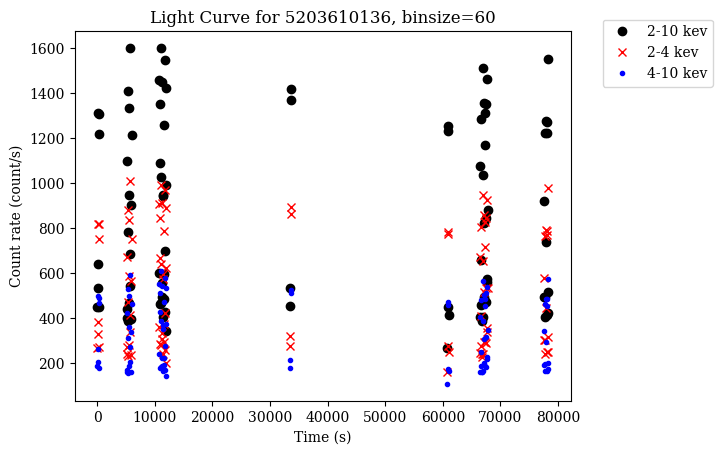

In [31]:
plt.plot(lc_data(tot36_60)[0],lc_data(tot36_60)[1],'o', color= 'black', label='2-10 kev')
plt.plot(lc_data(soft36_60)[0],lc_data(soft36_60)[1], 'red', marker='x',linestyle='', label='2-4 kev')
plt.plot(lc_data(hard36_60)[0],lc_data(hard36_60)[1], 'blue', marker='.',linestyle='', label='4-10 kev')

plt.title("Light Curve for 5203610136, binsize=60")
plt.xlabel("Time (s)")
plt.ylabel("Count rate (count/s)")
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

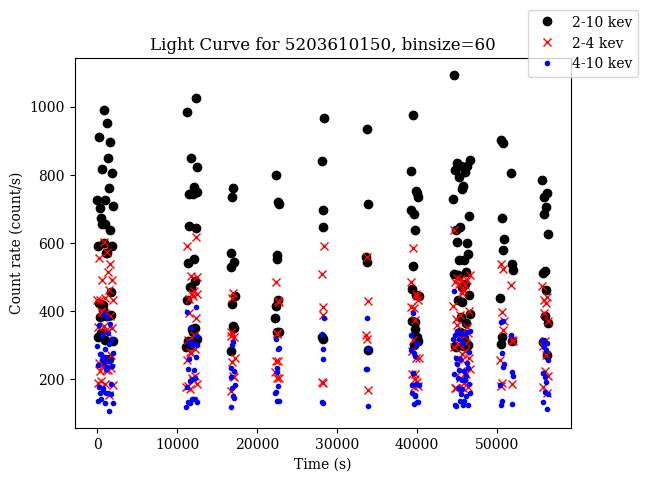

In [32]:
plt.plot(lc_data(tot50_60)[0],lc_data(tot50_60)[1],'o', color= 'black', label='2-10 kev')
plt.plot(lc_data(soft50_60)[0],lc_data(soft50_60)[1], 'red', marker='x',linestyle='', label='2-4 kev')
plt.plot(lc_data(hard50_60)[0],lc_data(hard50_60)[1], 'blue', marker='.',linestyle='', label='4-10 kev')

plt.title("Light Curve for 5203610150, binsize=60")
plt.xlabel("Time (s)")
plt.ylabel("Count rate (count/s)")
plt.legend(bbox_to_anchor=(1.15, 1.15))
plt.show()

## Calculating the Hardness ratio <a class="anchor" id="second-bullet"></a>

### Hardness ratio plot for this source: https://arxiv.org/pdf/2306.08083.pdf

In [33]:
############################
# Function by Joel Coley
# Create a function to derive the hardness ratio using the definition (H-S)/(H+S)
############################
def hratio(rate1,rate2,error1,error2):
    calcHR=np.divide(np.subtract(rate2,rate1),np.add(rate2,rate1))
    calcerror=np.sqrt(np.add(np.multiply(np.power(np.divide(np.multiply(2.,rate1),np.power(np.add(rate2,rate1),2.)),2.),np.power(error2,2.)),np.multiply(np.power(np.divide(np.multiply(2.,rate2),np.power(np.add(rate2,rate1),2.)),2.),np.power(error1,2.))))
    return [calcHR,calcerror]

### First, we calculate the HR for individual obsIDs with 60 second bins, with the exception of one 10 second bin.

In [34]:
#Use time from light curve plots.
time09= lc_data(soft09_60)[0]
time22= lc_data(soft22_60)[0]
time36= lc_data(soft36_60)[0]
time50= lc_data(soft50_60)[0]

In [35]:
#obsID 5203610109, binsize=60
hr09_60=[]
hr_err09_60=[]
for i in range(len(time09)):
    a=hratio( (lc_data(soft09_60)[1])[i], (lc_data(hard09_60)[1])[i], (lc_data(soft09_60)[2])[i], (lc_data(hard09_60)[2])[i])
    hr09_60.append(a[0])
    hr_err09_60.append(a[1])

In [36]:
#obsID 5203610122, binsize=60
hr22_60=[]
hr_err22_60=[]
for i in range(len(time22)):
    a=hratio( (lc_data(soft22_60)[1])[i], (lc_data(hard22_60)[1])[i], (lc_data(soft22_60)[1])[i], (lc_data(hard22_60)[1])[i])
    hr22_60.append(a[0])
    hr_err22_60.append(a[1])

In [37]:
#obsID 5203610136, binsize=60
hr36_60=[]
hr_err36_60=[]
for i in range(len(time36)):
    a=hratio(lc_data(soft36_60)[1][i], lc_data(hard36_60)[1][i], lc_data(soft36_60)[2][i], lc_data(hard36_60)[2][i])
    hr36_60.append(a[0])
    hr_err36_60.append(a[1])

In [38]:
#obsID 5203610150, binsize=60
hr50_60=[]
hr_err50_60=[]
for i in range(len(time50)):
    a=hratio(lc_data(soft50_60)[1][i], lc_data(hard50_60)[1][i], lc_data(soft50_60)[2][i], lc_data(hard50_60)[2][i])
    hr50_60.append(a[0])
    hr_err50_60.append(a[1])

### Now, we rebin the light curves to 1 bin per obsID, to obtain one HR per obsID.

In [40]:
############################
# Function by Joel Coley
# Create a function to bin the light curve to a desired binsize
############################
def lcrebin(npts,num,time,rate,error,t1,t2,dt):
    rn=[] 
    ern=[]
    dnbin=[]
    k=0
    tlimit=[]
    #make a new time limit
    for i in range(np.add(num,1)): # for i in range num+1
        tlimit.append(np.add(t1,np.multiply(dt,i))) #store (t1 + (dt*i)) in array tlimit
    #make arrays of zero
    for i in range(np.add(num,1)): #for i in range num+1
        rn.append(0.0) #fill array rn with zeroes
        ern.append(0.0) #fill array ern with zeroes
    new_a=[]
    dnbin=[]
    for i in range(np.add(num,1)):
        index1=np.where(time < tlimit[i])
        if tlimit[i] != tlimit[0]:
            index2=np.where(time < tlimit[np.subtract(i,1)])
            new_a.append(np.delete(index1,index2))
            dnbin.append(len(new_a[i]))
        if tlimit[i] == tlimit[0]:
            new_a.append(index1)
            dnbin.append(len(new_a[i]))
            
    maxIndexReport=pd.Series(tlimit).idxmax() #remove data point with max value
    lc1xbin=np.delete(tlimit, maxIndexReport) #delete maxindexreport from array
    dnbin=np.delete(dnbin,[0]) #delete first value in dnbin
    my_index=new_a[1] #delete first value in my_index
    lc1bins=[]
    lc1berr=[]
    lc1dxbin=[]
    #print(len(my_index))
    for i in range(np.add(num,1)):
        for j in range(len(my_index)):
            rn[i]=np.add(rn[i],rate[my_index[j]])
            ern[i]=np.add(ern[i],np.power(error[my_index[j]],2.))     
        lc1bins.append(np.divide(rn[i],dnbin))
        lc1berr.append(np.divide(np.sqrt(ern[i]),dnbin))
        lc1dxbin.append(np.divide(dt,2.))

    # Here we need to get rid of the NANs
    nanindex=[]
    for i in range(len(lc1bins)):
        if np.isnan(lc1bins[i]):
            print("%.0f" % (i))
            nanindex.append(i)

    lc1xbin=np.delete(lc1xbin,nanindex)
    lc1bins=np.delete(lc1bins,nanindex)
    lc1berr=np.delete(lc1berr,nanindex)
    lc1dxbin=np.delete(lc1dxbin,nanindex)

    return [lc1xbin,lc1bins,lc1berr,lc1dxbin]

### Define number of bins per obsID for hardness ratio calculation:

In [41]:
#function to rebin soft, hard, and total ranges at one time from Joel Coley
joelbin=1#number of points in new bin
def groupbin(soft, hard, total):
    #SOFT
    time=lc_data(soft)[0]
    softrate=lc_data(soft)[1]
    softerror=lc_data(soft)[2]
    tstart=min(time)
    tend=max(time)
    dt=(tend-tstart)/joelbin
    npts=len(time)
    num=np.divide(np.subtract(tend,tstart),dt).astype(int)
    #We call the function using the following:
    s36=lcrebin(npts,num,time,softrate,softerror,tstart,tend,dt)
    
    #HARD
    time=lc_data(hard)[0]
    hardrate=lc_data(hard)[1]
    harderror=lc_data(hard)[2]
    tstart=min(time)
    tend=max(time)
    dt=(tend-tstart)/joelbin
    npts=len(time)
    num=np.divide(np.subtract(tend,tstart),dt).astype(int)
    h36=lcrebin(npts,num,time,hardrate,harderror,tstart,tend,dt)
    
    #TOT
    time=lc_data(total)[0]
    totrate=lc_data(total)[1]
    toterror=lc_data(total)[2]
    tstart=min(time)
    tend=max(time)
    dt=(tend-tstart)/joelbin
    npts=len(time)
    num=np.divide(np.subtract(tend,tstart),dt).astype(int)
    t36=lcrebin(npts,num,time,totrate,toterror,tstart,tend,dt)
    
    return(s36,h36,t36)

In [42]:
soft09,hard09,tot09=groupbin(soft09_60,hard09_60,tot09_60)

In [43]:
soft22,hard22,tot22=groupbin(soft22_60,hard22_60,tot22_60)

In [44]:
soft36,hard36,tot36=groupbin(soft36_60,hard36_60,tot36_60)

In [45]:
soft50,hard50,tot50=groupbin(soft50_60,hard50_60,tot50_60)

### Caluclate new hardness ratio:

In [46]:
##obsID 5203610109, binsize=60
a=hratio( soft09[1], hard09[1], soft09[2], hard09[2])
hr09=(a[0])[0]
hr_err09=(a[1])[0]

In [47]:
##obsID 5203610122, binsize=60
a=hratio( soft22[1], hard22[1], soft22[2], hard22[2])
hr22=(a[0])[0]
hr_err22=(a[1])[0]

In [48]:
##obsID 5203610136, binsize=60
a=hratio( soft36[1], hard36[1], soft36[2], hard36[2])
hr36=(a[0])[0]
hr_err36=(a[1])[0]

In [49]:
##obsID 5203610150, binsize=60
a=hratio( soft50[1], hard50[1], soft50[2], hard50[2])
hr50=(a[0])[0]
hr_err50=(a[1])[0]

## Hardness Intensity Diagram<a class="anchor" id="HID"></a>

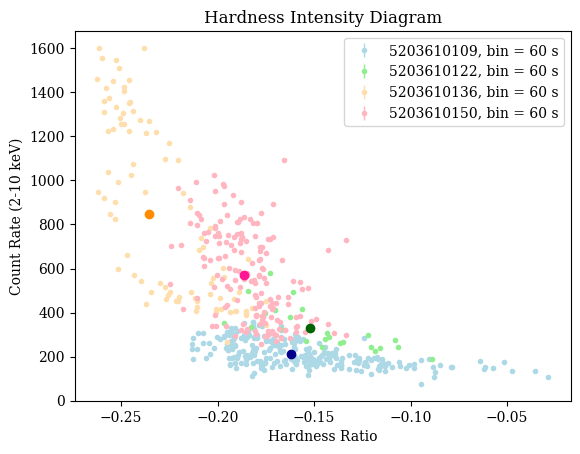

In [50]:
plt.errorbar(hr09_60, lc_data(tot09_60)[1], yerr = hr_err09_60, fmt ='.', color='lightblue', label= '5203610109, bin = 60 s')
plt.errorbar(hr22_60, lc_data(tot22_60)[1], yerr = hr_err22_60, fmt ='.', color='lightgreen', label= '5203610122, bin = 60 s')
plt.errorbar(hr36_60, lc_data(tot36_60)[1], yerr = hr_err36_60, fmt ='.', color='navajowhite', label= '5203610136, bin = 60 s')
plt.errorbar(hr50_60, lc_data(tot50_60)[1], yerr = hr_err50_60, fmt ='.', color='lightpink', label= '5203610150, bin = 60 s')
plt.errorbar(hr09, tot09[1][0], yerr=hr_err09, fmt='o', color = 'darkblue')#,label='Full 5203610109')
plt.errorbar(hr22, tot22[1][0], yerr=hr_err22, fmt='o', color = 'darkgreen')#,label='Full 5203610122')
plt.errorbar(hr36, tot36[1][0], yerr=hr_err36, fmt='o', color = 'darkorange')#,label='Full 5203610136')
plt.errorbar(hr50, tot50[1][0], yerr=hr_err50, fmt='o', color = 'deeppink')#,label='Full 5203610150')

plt.xlabel('Hardness Ratio')
plt.ylabel('Count Rate (2-10 keV)')
plt.title('Hardness Intensity Diagram')# for obsID 5203610109')
plt.legend()
plt.show()

## Using Stingray <a class="anchor" id="third-bullet"></a>

### Use stingray package to perform time series analysis on light curves, including Fourier analysis.

### Load nicer event list, cleaned and barycentered.

In [51]:
#events = EventList.read("5203610109/xti/event_cl/ni5203610109_0mpu7_cl.evt", "hea")
evbar = EventList.read("5203610109/xti/event_cl/ni5203610109_0mpu7_cl_bar.evt", "hea")

/Users/mdethero/miniforge3/lib/python3.10/site-packages/stingray/io.py:239: UserWarning: Column energy not found
  warnings.warn("Column " + a + " not found")


#### Create light curve, apply GTIs

In [52]:
lc_raw = evbar.to_lc(dt=1)
lc_raw.apply_gtis()

In [53]:
time = lc_raw.time#/(3600*24)
ctrate_err = lc_raw.countrate_err
ctrate = lc_raw.countrate

Text(0, 0.5, 'Counts/s bin')

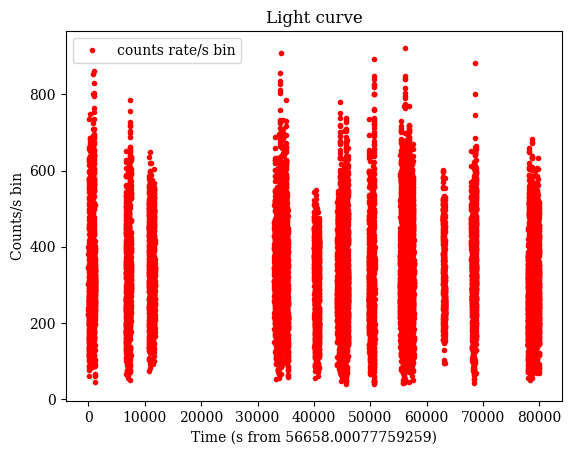

In [54]:
plt.figure()
plt.plot(lc_raw.time-lc_raw.time[0],lc_raw.countrate, color='red', marker='.',linestyle='', label='counts rate/s bin')
plt.legend()
plt.title("Light curve")
plt.xlabel(f"Time (s from {evbar.mjdref})")
plt.ylabel(f"Counts/s bin")

### To clean out zero counts/make new GTIs etc:

#### Create new GTIs, apply to new light curve "lc"

In [55]:
new_gti = create_gti_from_condition(lc_raw.time, lc_raw.counts > 0, safe_interval=1)
lc = copy.deepcopy(lc_raw) #copy lc_raw to lc
lc.gti = new_gti
lc.apply_gtis()

## Create a periodogram (power spectrum)
### Modified example code from https://docs.stingray.science/notebooks/Spectral%20Timing/Spectral%20Timing%20Exploration.html#Calculate-periodogram-and-cross-spectrum

####  Calculate periodogram:
* "frac" = Fractional rms normalization: type of normalization for the power spectrum, uses mean count rate. 

In [56]:
# Calculate the periodogram in fractional rms normalization.
# Length in seconds of each light curve segment
segment_size=850
# Sampling time of the light curve: 1ms, this will give a Nyquist
# frequency of 0.3 / dt = 600 Hz.
dt=3 # should not be smaller than bin size 
# Fractional rms normalization
norm="frac"
#f= np.arange(0.002,0.006,1e4)
pds=AveragedPowerspectrum.from_events(evbar, segment_size=segment_size,  dt=dt, norm=norm, use_common_mean=True)

# Calculate the mean count rate
ctrate = get_average_ctrate(evbar.time, evbar.gti, segment_size)
# Calculate the Poisson noise level
noise = poisson_level(norm, meanrate=ctrate)

# Rebin the periodogam
pds_reb = pds.rebin_log(0.02)

14it [00:00, 148.68it/s]


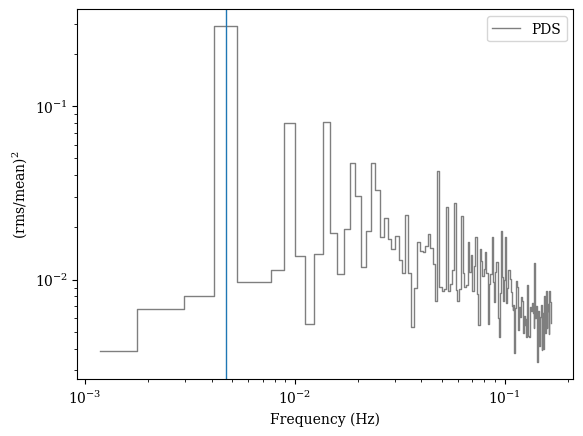

In [57]:
plt.figure()
plt.plot(pds.freq, (pds.power - noise) * pds.freq, drawstyle="steps-mid", color="black", alpha=0.5, label="PDS")
plt.axvline((pds.freq[np.where(((pds.power - noise) * pds.freq)==max((pds.power - noise) * pds.freq))]))
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");
plt.legend();

In [58]:
period= 1/(pds.freq[np.where(((pds.power - noise) * pds.freq)==max((pds.power - noise) * pds.freq))])   
print("Period calculated from pds = ", period, "seconds." )

Period calculated from pds =  [212.5] seconds.


## Z Squared<a class="anchor" id="fourth-bullet"></a>

In [59]:
nharm = 1
nbin=(len(time09))
fr_chose=np.arange(1/350,.006,1e-5)

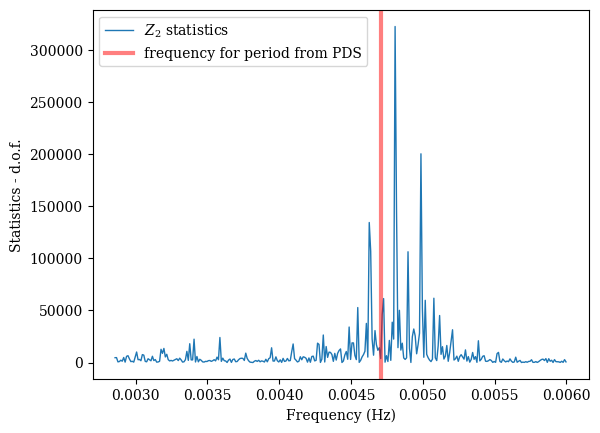

In [60]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
freq, zstat = z_n_search(evbar.time, fr_chose, nbin=nbin, nharm=nharm)
# ---- PLOTTING --------
plt.figure()
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='frequency for period from PDS')
#plt.xlim(freq[0], 0.20)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

In [61]:
myperiod=1/(fr_chose[np.where(zstat==max(zstat))][0])
print("Calculated period from zsquared is: ",myperiod, "seconds")

Calculated period from zsquared is:  208.02377414561641 seconds


## Phase Folded Light Curve<a class="anchor" id="fifth-bullet"></a>

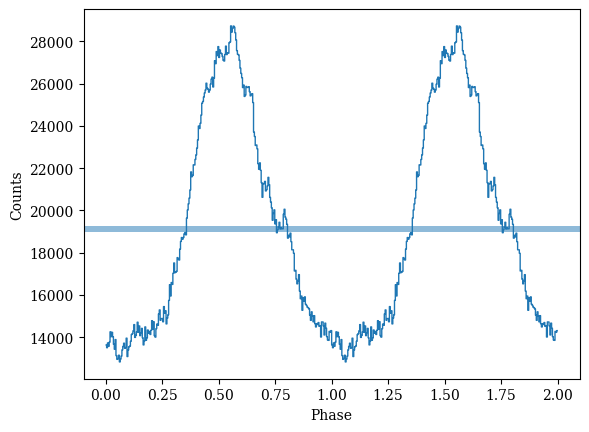

In [62]:
#pulse profile or phaseogram
ph, profile, profile_err = fold_events(evbar.time, 1/myperiod, nbin=nbin)
_ = plot_profile(ph, profile)